# Data visualization for the different parks separately

In the process of data preprocessing, the bolded out points below is the focus of this notebook.

Plan:

- Transform data
    - Pretend current wind predictions are measurements
    - Transform degrees into cos and sin values

- Divide into parks, and for each park:
    - Overview over NaN values and how to deal with them
    - **Autocorrelation over wind speed, wind direction, production**
    - **How much does the wind speed and wind direction change when the forecast is updated?**
    - **How is the wind speed and the production correlated?**

- Look at data for all parks
    - Normalize data for all parks (max production at each park is 1)
    - Look at correlations between production at the different parks
    - Look at correlations again, this time after splitting the data into wind direction quadrant

The data used for this visualization is the data where the missing values are filled. The visualization will be repeated at the end or in a new notebook, in order to see whether some of the qualitative observations change due to this difference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, acf, pacf, plot_pacf

import sys
import os

from satprod.data_handlers.num_data import NumericalDataHandler

In [2]:
pd.set_option("display.max_rows", 700, "display.max_columns", 50)

In [3]:
num = NumericalDataHandler()

data = num.read_old_formatted_data(nan=True)

# the no nan data is not available for the test set times, so there is nothing to remove
#split = datetime(2020, 5, 1, 0)
#enc_df = enc_df[enc_df.index < split]
#dec_df = dec_df[dec_df.index < split]

In [4]:
dev_mode = False # to not have to scroll over all the plots when coding

## Functions

In [5]:
def wind_speed_plots(park: str):
    #acf_wind = acf(enc_df[f'wind_speed_{park}'].dropna(axis=0).values, nlags=24*14, fft=False)
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*30)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_pacf(data[f'wind_speed_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()
    
def wind_speed_forecast_change(park: str):
    ch_wind = (data[f'wind_speed_{park}+1h'].shift()-data[f'wind_speed_{park}'])
    
    # remove all rows where there was no update in the forecasts, and use absolute values
    ch_wind = ch_wind[np.abs(ch_wind) > 1e-6]
    
    plt.figure(figsize=(16,4))
    ch_wind.plot()
    plt.title('Wind speed forecast change when updated')
    plt.show()
    
    print(f'Mean forecast change when updated: {np.mean(ch_wind)}.')
    
    plt.figure(figsize=(16,4))
    np.abs(ch_wind).plot()
    plt.title('Wind speed forecast absolute change when updated')
    plt.show()
    
    print(f'Mean forecast absolute change when updated: {np.mean(np.abs(ch_wind))}.')

def wind_direction_plots(park: str):
    plot_acf(data[f'wind_direction_{park}_sin'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_acf(data[f'wind_direction_{park}_cos'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()

    plot_pacf(data[f'wind_direction_{park}_sin'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_pacf(data[f'wind_direction_{park}_cos'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()
    
def wind_direction_forecast_change(park: str):
    ch_dir_sin = (data[f'wind_direction_{park}_sin+1h'].shift()-data[f'wind_direction_{park}_sin'])
    ch_dir_cos = (data[f'wind_direction_{park}_cos+1h'].shift()-data[f'wind_direction_{park}_cos'])

    # remove all rows where there was no update in the forecasts, and use absolute values
    ch_dir_sin = ch_dir_sin[np.abs(ch_dir_sin) > 1e-6]
    ch_dir_cos = ch_dir_cos[np.abs(ch_dir_cos) > 1e-6]

    plt.figure(figsize=(16,4))
    ch_dir_sin.plot()
    plt.title('Wind direction sine forecast change when updated')
    plt.show()

    plt.figure(figsize=(16,4))
    ch_dir_cos.plot()
    plt.title('Wind direction cosine forecast change when updated')
    plt.show()

    print(f'Mean sine forecast change when updated: {np.mean(ch_dir_sin)}.')
    print(f'Mean cosine forecast change when updated: {np.mean(ch_dir_cos)}.')

    plt.figure(figsize=(16,4))
    np.abs(ch_dir_sin).plot()
    plt.title('Wind direction sine forecast absolute change when updated')
    plt.show()

    plt.figure(figsize=(16,4))
    np.abs(ch_dir_cos).plot()
    plt.title('Wind direction cosine forecast absolute change when updated')
    plt.show()

    print(f'Mean sine forecast absolute change when updated: {np.mean(np.abs(ch_dir_sin))}.')
    print(f'Mean cos forecast absolute change when updated: {np.mean(np.abs(ch_dir_cos))}.')
    
def production_plots(park: str):
    fig = plot_acf(data[f'production_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()

    fig = plot_acf(data[f'production_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()

    fig = plot_pacf(data[f'production_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()
    
def prod_wind_speed_correlation(park):
    prod_shift_df = pd.DataFrame()
    names = []
    for i in range(0, 5):
        new = data[f'production_{park}'].shift(i)
        names.append(f'production_{park}_shift_{i}')
        prod_shift_df = pd.concat([prod_shift_df, new], axis=1)
    prod_shift_df.columns = names

    wind_shift_df = pd.DataFrame()
    names = []
    for i in range(0, 5):
        new = data[f'wind_speed_{park}'].shift(i)
        names.append(f'wind_speed_{park}_shift_{i}')
        wind_shift_df = pd.concat([wind_shift_df, new], axis=1)
    wind_shift_df.columns = names

    combo = pd.concat([wind_shift_df, prod_shift_df], axis=1)
    del wind_shift_df, prod_shift_df

    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(combo.corr(), ax=ax)
    plt.show()

## Bessaker

### Wind speed

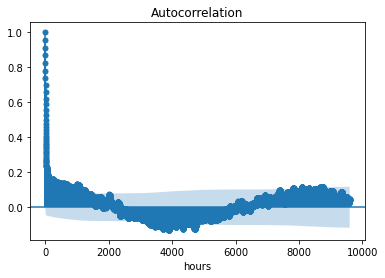

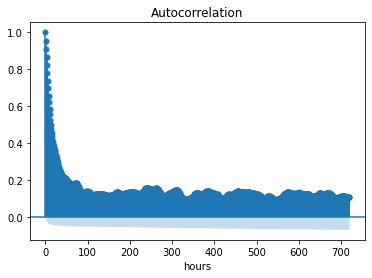

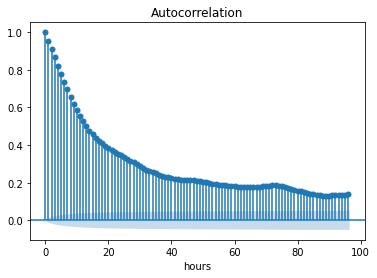

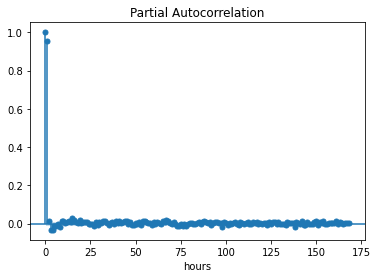

In [6]:
if not dev_mode: wind_speed_plots('bess')

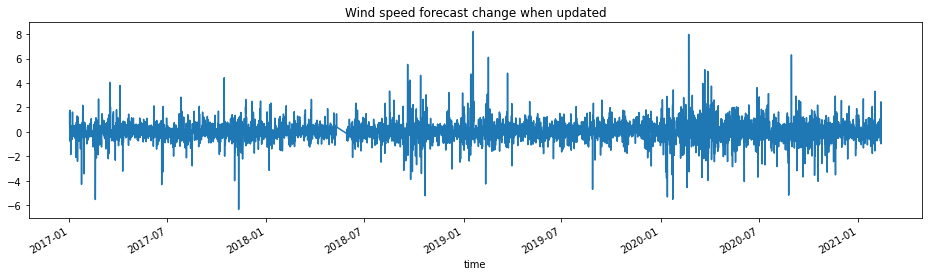

Mean forecast change when updated: 0.03350830669590023.


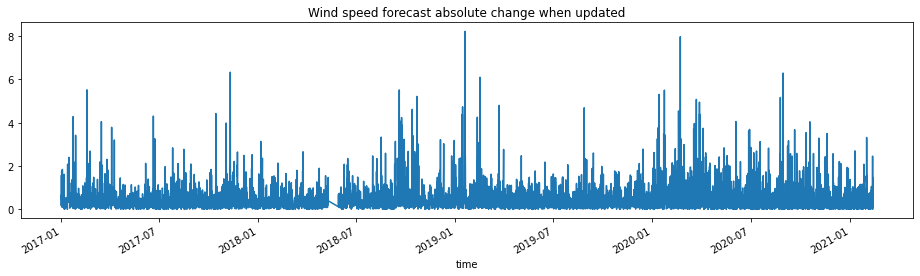

Mean forecast absolute change when updated: 0.4947826072010485.


In [7]:
if not dev_mode: wind_speed_forecast_change('bess')

The forecasts are rarely corrected by more than $2$ m/s, and on average just $0.5$ m/s. 

### Wind direction

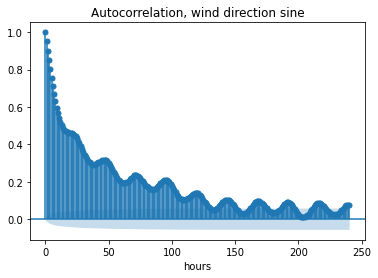

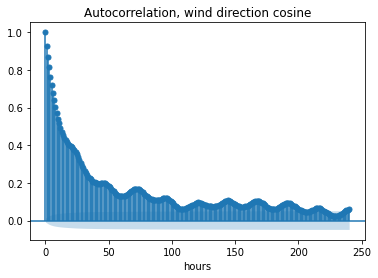

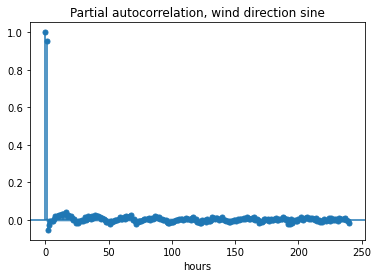

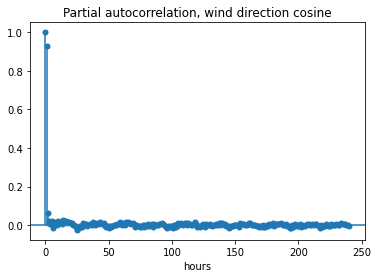

In [8]:
if not dev_mode: wind_direction_plots('bess')

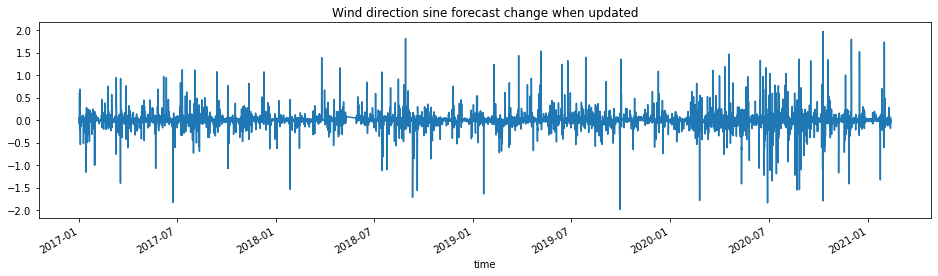

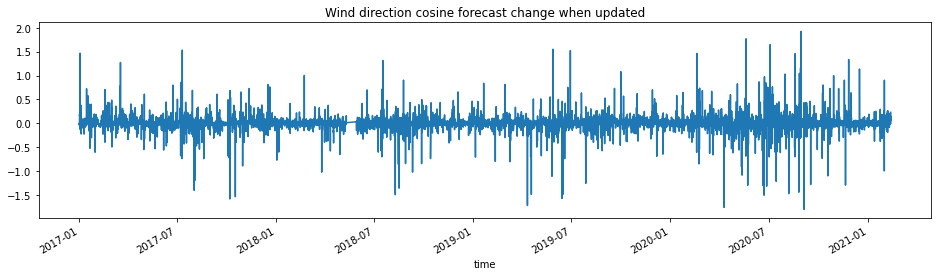

Mean sine forecast change when updated: 0.001079293787270987.
Mean cosine forecast change when updated: 0.005826859119155994.


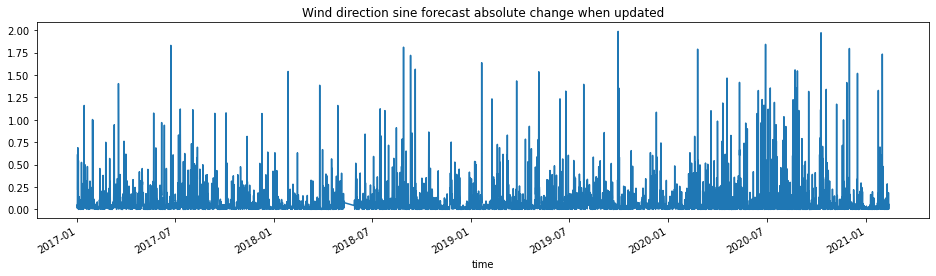

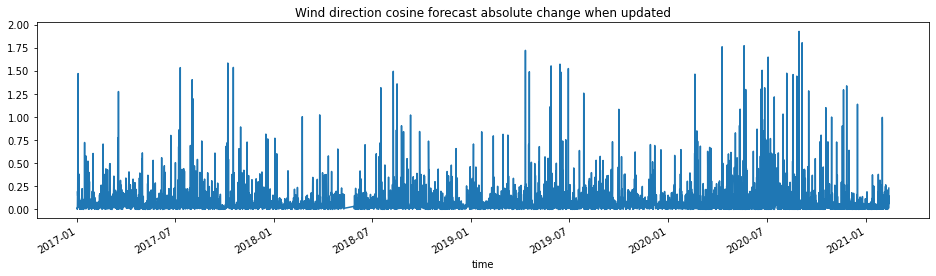

Mean sine forecast absolute change when updated: 0.08126385017208941.
Mean cos forecast absolute change when updated: 0.08721137053325992.


In [9]:
if not dev_mode: wind_direction_forecast_change('bess')

### Production

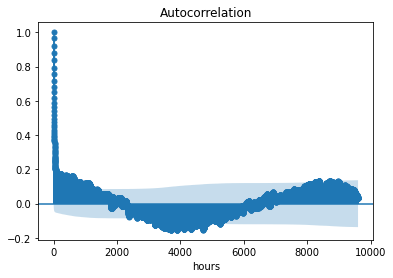

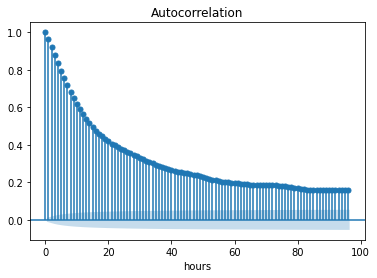

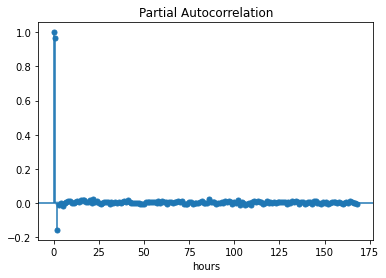

In [10]:
if not dev_mode: production_plots('bess')

### Relation between wind speed and production

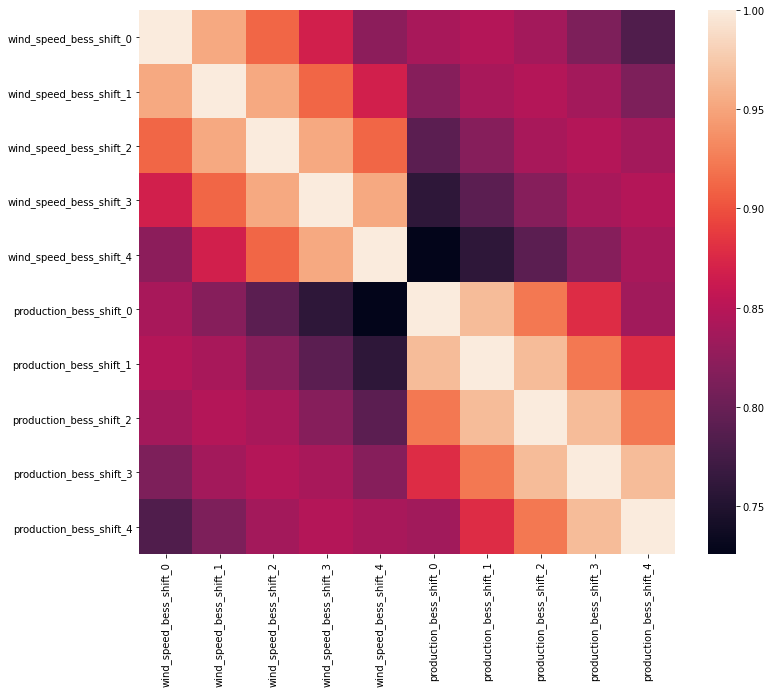

In [11]:
if not dev_mode: prod_wind_speed_correlation('bess')

Production is most correlated with the wind speed in the previous hour. That is a helpful relation for the forecasting model.

## Skomaker

Numerical forecasts at Skomakerfjellet are identical to the ones at Bessakerfjellet, and the plots are therefore not repeated. Production is, however, not identical, and is therefore shown.

### Production

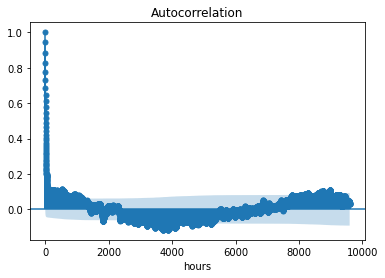

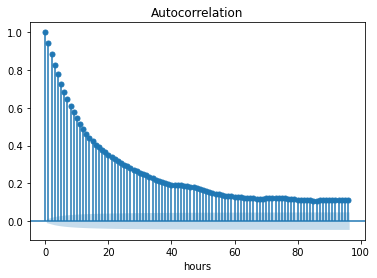

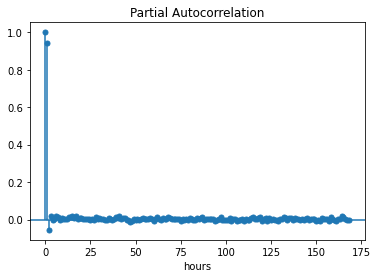

In [12]:
if not dev_mode: production_plots('skom')

### Relation between wind speed, wind direction, and production

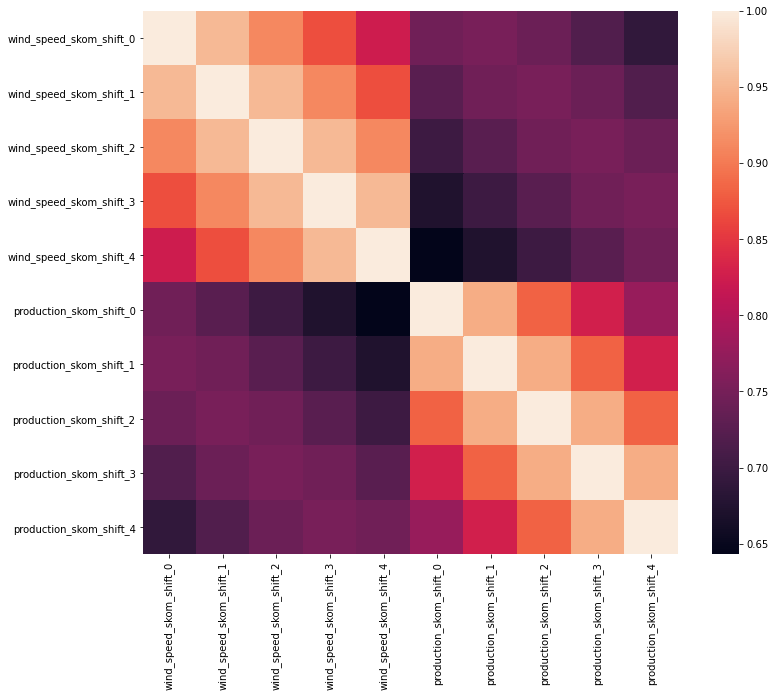

In [13]:
if not dev_mode: prod_wind_speed_correlation('skom')

## Valsneset

### Wind speed

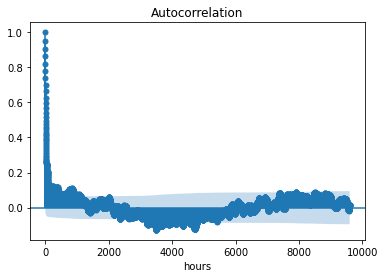

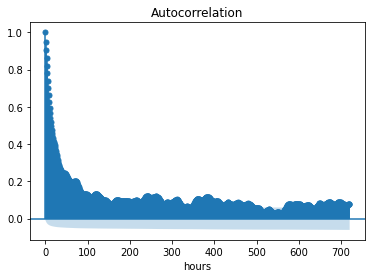

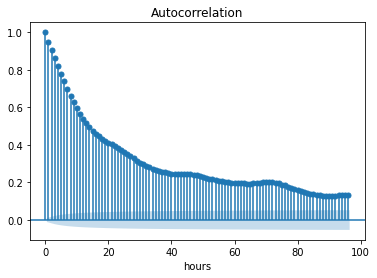

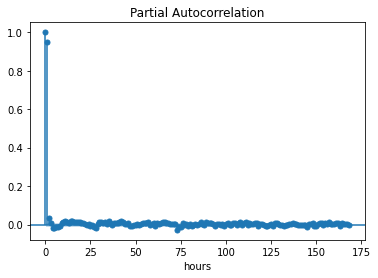

In [14]:
if not dev_mode: wind_speed_plots('vals')

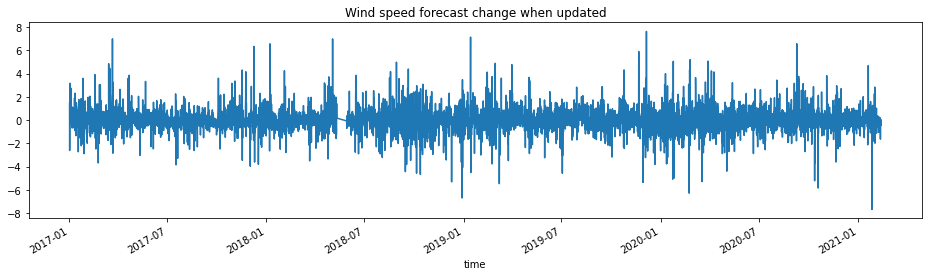

Mean forecast change when updated: 0.032376130856324695.


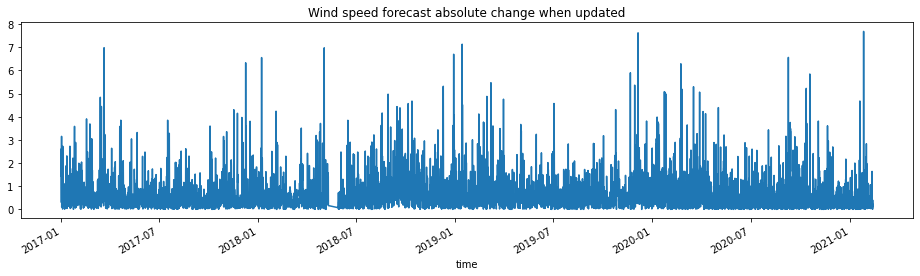

Mean forecast absolute change when updated: 0.6239745887369408.


In [15]:
if not dev_mode: wind_speed_forecast_change('vals')

### Wind direction

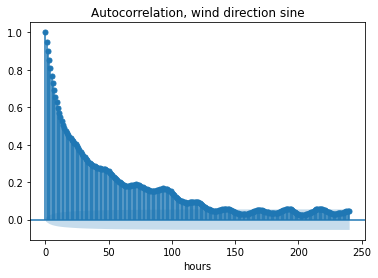

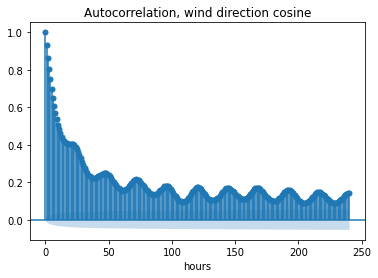

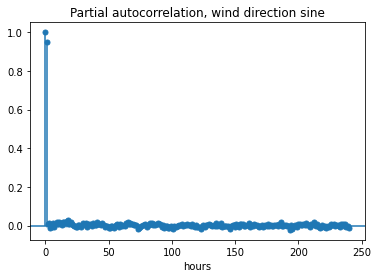

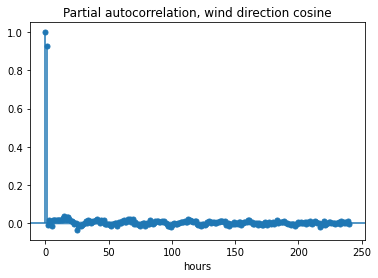

In [16]:
if not dev_mode: wind_direction_plots('vals')

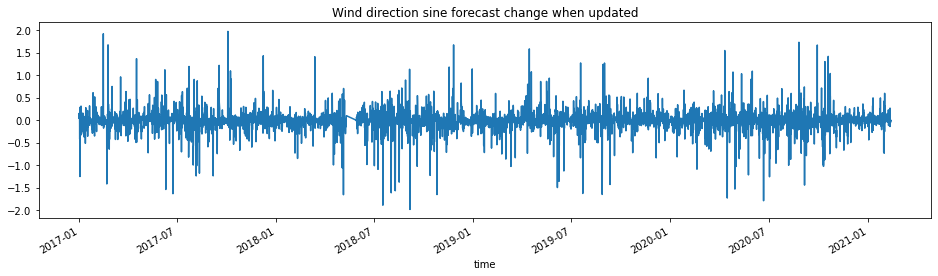

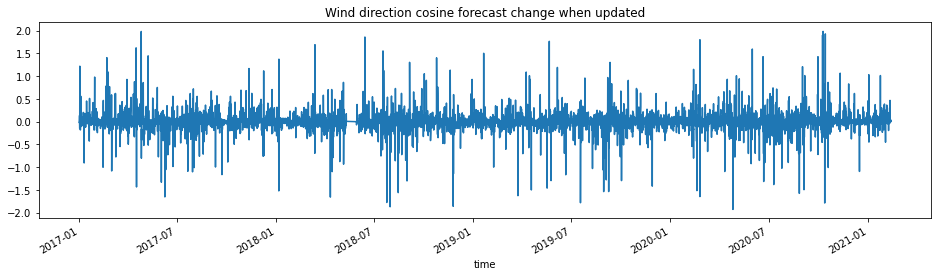

Mean sine forecast change when updated: -0.0049896071944488295.
Mean cosine forecast change when updated: 0.00584948524997673.


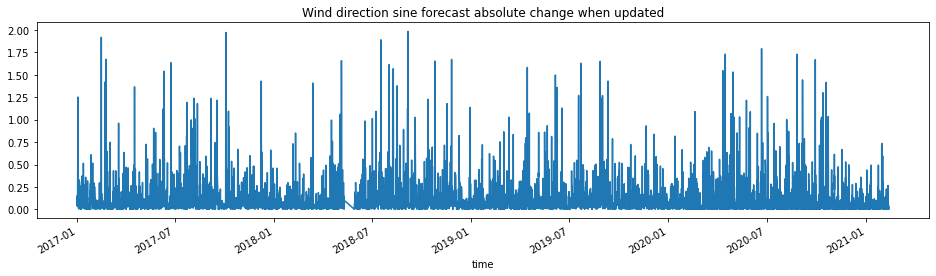

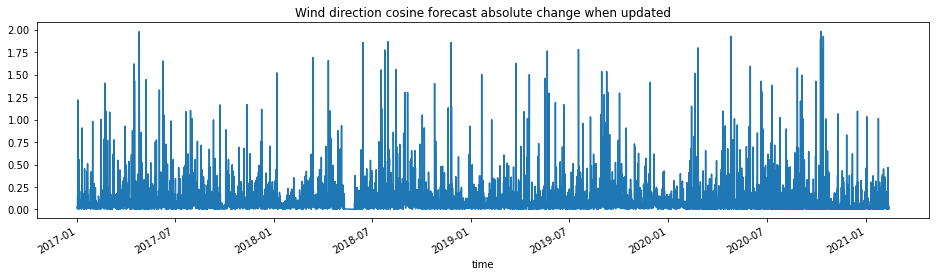

Mean sine forecast absolute change when updated: 0.10795027232849977.
Mean cos forecast absolute change when updated: 0.10996162784248653.


In [17]:
if not dev_mode: wind_direction_forecast_change('vals')

### Production

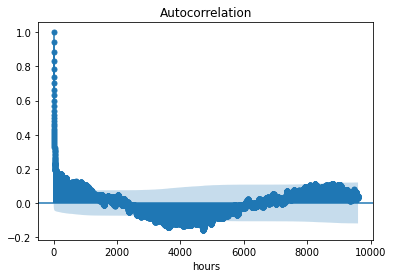

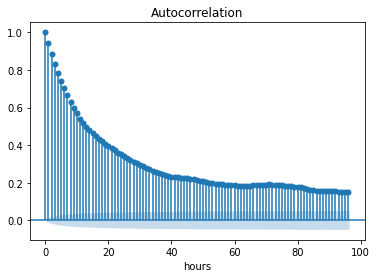

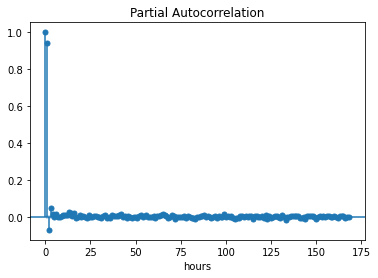

In [18]:
if not dev_mode: production_plots('vals')

### Relation between wind speed, wind direction, and production

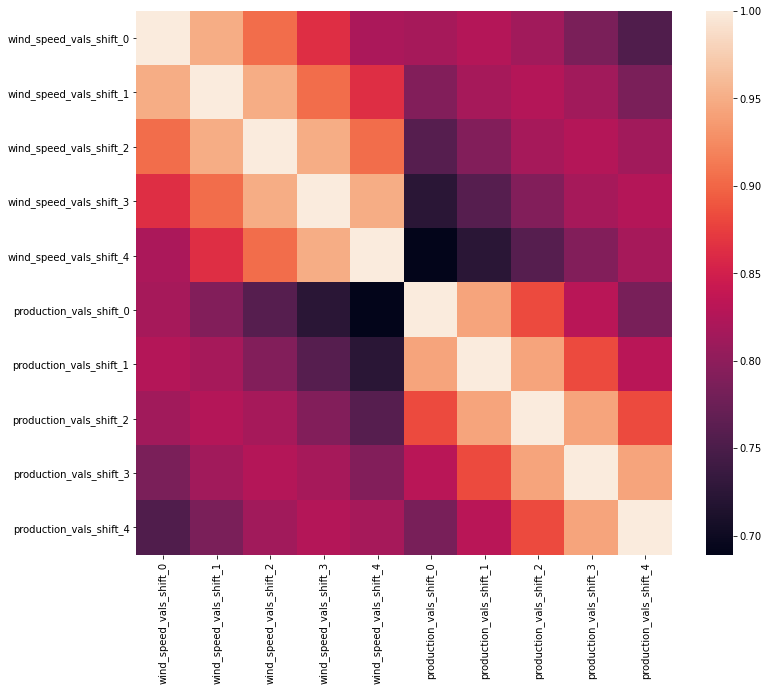

In [19]:
if not dev_mode: prod_wind_speed_correlation('vals')

## Ytre vikna

### Wind speed

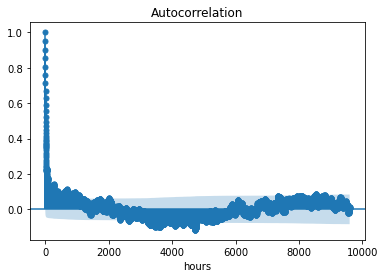

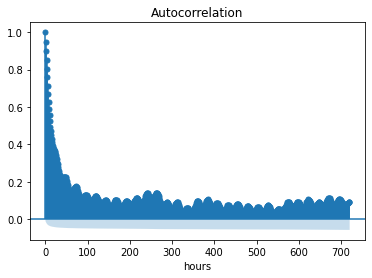

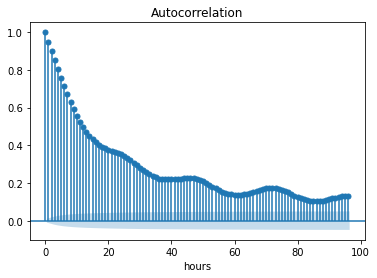

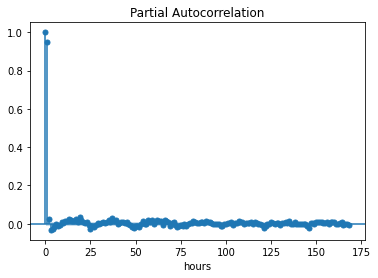

In [20]:
if not dev_mode: wind_speed_plots('yvik')

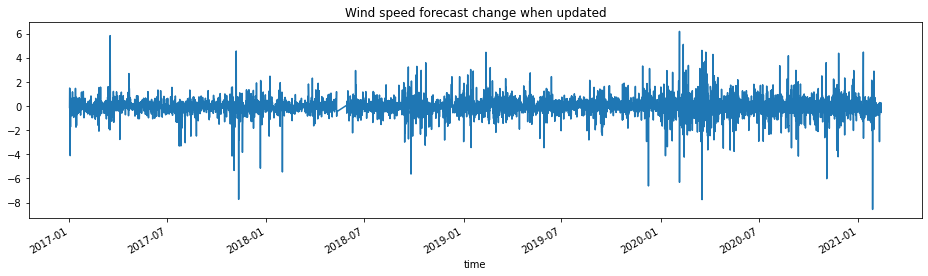

Mean forecast change when updated: -0.03292560345105149.


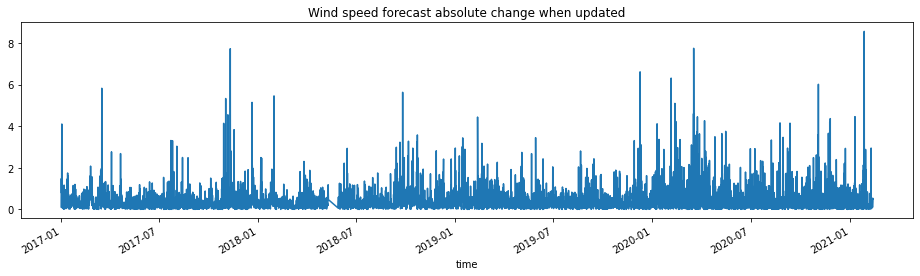

Mean forecast absolute change when updated: 0.44640831000111714.


In [21]:
if not dev_mode: wind_speed_forecast_change('yvik')

### Wind direction

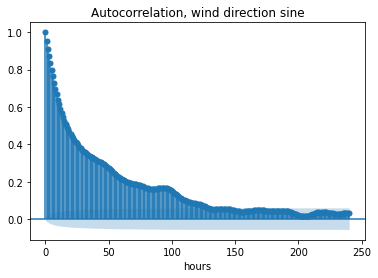

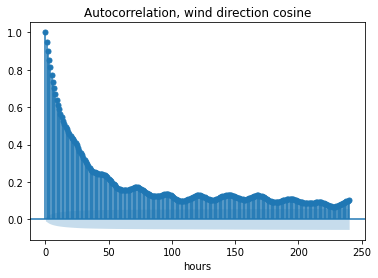

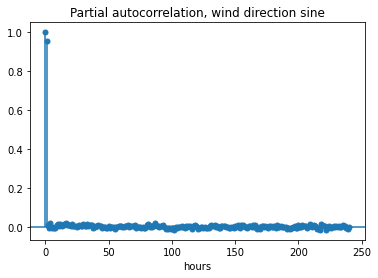

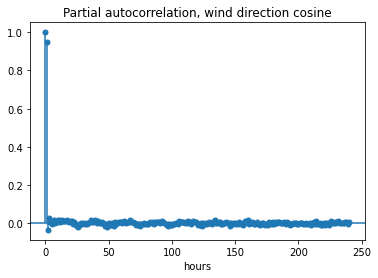

In [22]:
if not dev_mode: wind_direction_plots('yvik')

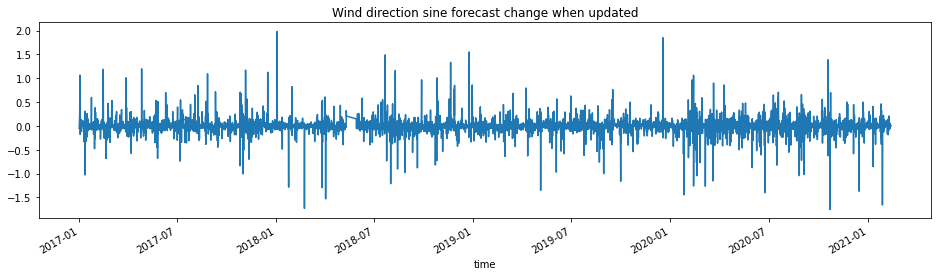

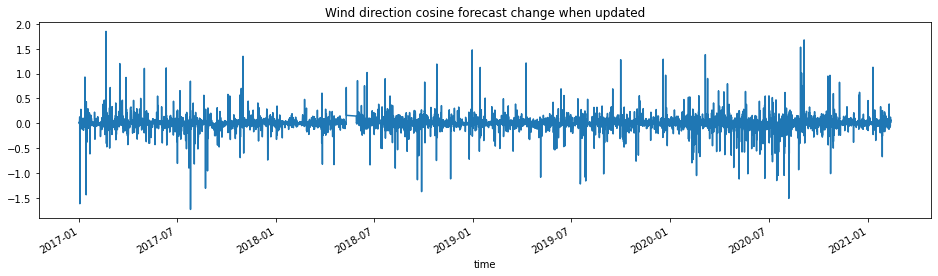

Mean sine forecast change when updated: 0.0012755300884434919.
Mean cosine forecast change when updated: 0.005303205494461802.


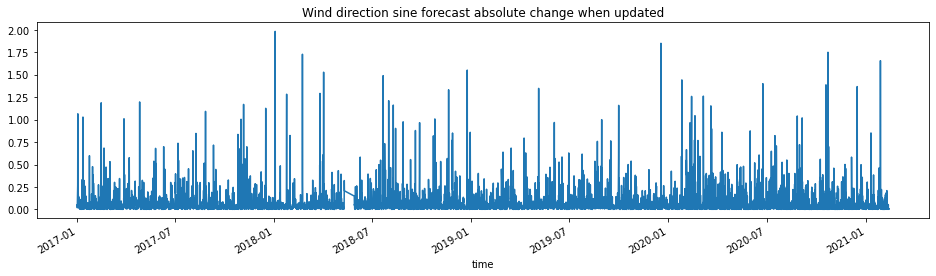

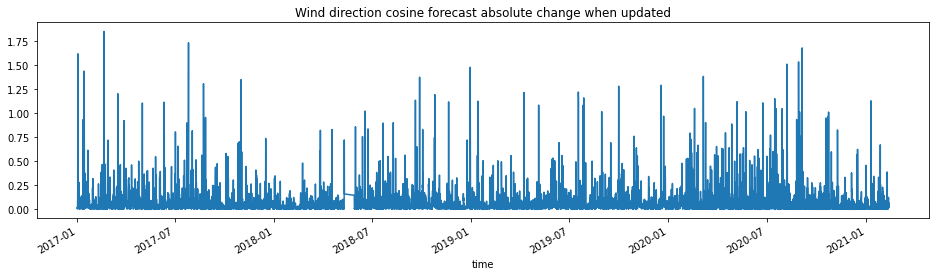

Mean sine forecast absolute change when updated: 0.0759639913145471.
Mean cos forecast absolute change when updated: 0.07365595846332405.


In [23]:
if not dev_mode: wind_direction_forecast_change('yvik')

### Production

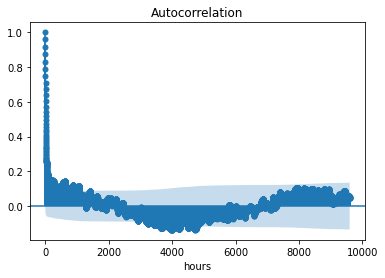

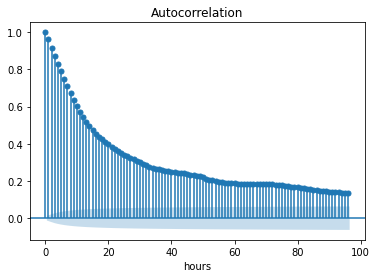

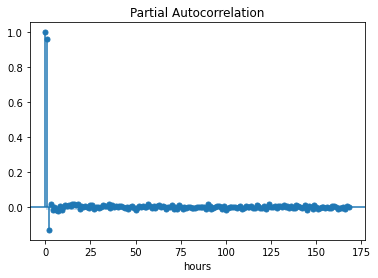

In [24]:
if not dev_mode: production_plots('yvik')

### Relation between wind speed, wind direction, and production

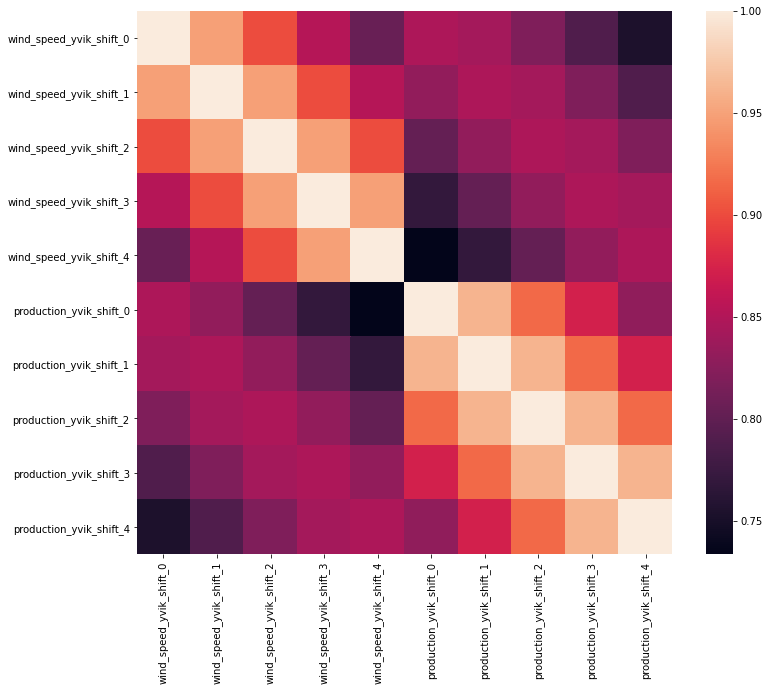

In [25]:
if not dev_mode: prod_wind_speed_correlation('yvik')